In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import os; print(os.getcwd())
import json

G:\Other computers\My Laptop\UW\Classes\ESS521\project\notebooks


In [3]:
from google.cloud.storage import Client

In [4]:
bucket = Client(project="forest-lst").bucket("forest-lst-tfdata")
spec = json.load(bucket.blob("ca_tree_mort/20_years/1.0.0/features.json").open())
spec = tfds.features.FeatureConnector.from_json(spec).get_tensor_spec()

In [5]:
spec

{'EVI_p5': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'EVI_p50': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'EVI_p95': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'dT_p5': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'dT_p50': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'dT_p95': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'elevation': TensorSpec(shape=(20,), dtype=tf.int64, name=None),
 'latitude': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'longitude': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'pct_mortality': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'prcp': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'spei30d_p5': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'spei30d_p50': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'spei30d_p95': TensorSpec(shape=(20,), dtype=tf.float32, name=None),
 'winter_tmin': TensorSpec(shape=(20,), dtype=tf.float32, name=N

In [6]:
def count_examples_in_dataset(bucket, prefix):
    c = Client()
    info_blob = next(f.name for f in c.list_blobs(bucket, prefix=prefix) if "dataset_info.json" in f.name)
    ds_info = json.load(c.bucket(bucket).blob(info_blob).open())
    return sum(map(int, ds_info["splits"][0]["shardLengths"]))

In [7]:
count_examples_in_dataset("forest-lst-tfdata", "ca_tree_mort/19_years")

3079

In [8]:
import matplotlib.pyplot as plt

years = list(range(2, 21))
data_dirs = ["ca_tree_mort/{}_years".format(y) for y in years]
counts = list(map(lambda x: count_examples_in_dataset("forest-lst-tfdata", x), data_dirs))

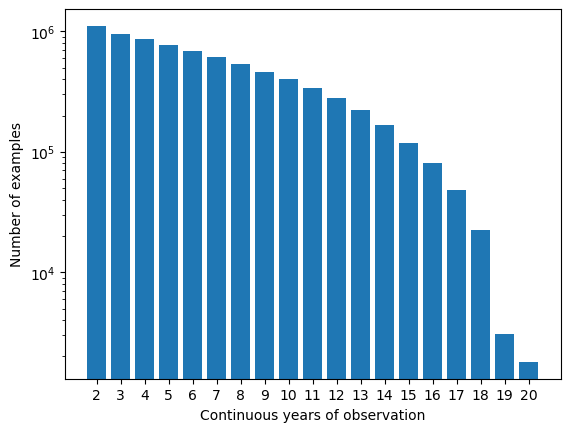

In [9]:
plt.bar(years, counts)
plt.xlabel("Continuous years of observation")
plt.ylabel("Number of examples")
plt.yscale("log")
plt.xticks(years)
plt.show()

In [10]:
tf.io.FixedLenFeature([5], tf.float32)

FixedLenFeature(shape=[5], dtype=tf.float32, default_value=None)

In [11]:
from google.cloud.storage import Client
import json

def read_dataset_gcs(bucket, prefix):
    c = Client()
    # Find all the files in the directory
    files = list(c.bucket(bucket).list_blobs(prefix=prefix))

    # Isolate TFRecords, feature info, dataset info
    records = ["/".join(["gs://{}".format(bucket), f.name]) for f in files if "tfrecord" in f.name]
    feats   = next(f.name for f in files if f.name.endswith("features.json"))
    ds_info = next(f.name for f in files if f.name.endswith("dataset_info.json"))

    # Convert TensorSpec to tf.io.FixedLenFeature
    spec = json.load(c.bucket(bucket).blob(feats).open())
    spec = tfds.features.FeatureConnector.from_json(spec).get_tensor_spec()

    spec_io = {
        key: tf.io.FixedLenFeature([spec[key].shape[0]], spec[key].dtype)
        for key in spec
    }

    # Read all the TFRecords
    ds = tf.data.TFRecordDataset(records)

    # Read dataset information and calculate size
    ds_info = json.load(c.bucket(bucket).blob(ds_info).open())
    ds_size = sum(map(int, ds_info["splits"][0]["shardLengths"]))
    
    return ds, spec_io, ds_size

In [12]:
ds, spec_io, ds_size = read_dataset_gcs("forest-lst-tfdata", "ca_tree_mort/20_years")

In [13]:
ds_size

1801

In [14]:
pct_train, pct_valid, pct_test = 0.70, 0.15, 0.15
n_train = int(ds_size * pct_train)
n_valid = int(ds_size * pct_valid)
n_test  = int(ds_size * pct_test)

ds_train = ds.take(n_train).shuffle(100)
ds_valid = ds.skip(n_train).take(n_valid).shuffle(100)
ds_test  = ds.skip(n_train).skip(n_valid).shuffle(100)

In [15]:
def decoder(proto):
    return tf.io.parse_single_example(proto, spec_io)

def split_input_output(example):
    popped = example.pop("pct_mortality")
    return example, {"pct_mortality": popped}

ds_train = ds_train.map(decoder).map(split_input_output)
ds_valid = ds_valid.map(decoder).map(split_input_output)
ds_test  = ds_test.map(decoder).map(split_input_output)

In [16]:
# Verify that we can read examples
next(iter(ds_train.take(1)))

({'EVI_p5': <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0.2477 , 0.1484 , 0.4508 , 0.3236 , 0.3436 , 0.31735, 0.3555 ,
         0.3547 , 0.31565, 0.4135 , 0.3582 , 0.4349 , 0.3767 , 0.3359 ,
         0.3756 , 0.3363 , 0.4172 , 0.23655, 0.3658 , 0.3521 ],
        dtype=float32)>,
  'EVI_p50': <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0.47105, 0.4863 , 0.5155 , 0.5157 , 0.5472 , 0.5136 , 0.5401 ,
         0.5032 , 0.5227 , 0.5028 , 0.5585 , 0.5491 , 0.55515, 0.52305,
         0.5223 , 0.55295, 0.51835, 0.5272 , 0.5059 , 0.5332 ],
        dtype=float32)>,
  'EVI_p95': <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([0.5545 , 0.5916 , 0.5942 , 0.5994 , 0.6213 , 0.59955, 0.5872 ,
         0.6133 , 0.61315, 0.606  , 0.6233 , 0.6218 , 0.6037 , 0.6037 ,
         0.6043 , 0.6289 , 0.5846 , 0.5933 , 0.5757 , 0.6176 ],
        dtype=float32)>,
  'dT_p5': <tf.Tensor: shape=(20,), dtype=float32, numpy=
  array([-2.9602444, -4.261935 , -4.4537387, -5.3883514, -3.6351

In [17]:
import tensorflow.keras as keras

REG = keras.regularizers.L1(0.001)
DROP = 0.05

def build_model(keys, time_series_length):
    # Read all the inputs
    inputs = [
        keras.layers.Input(shape=(time_series_length,), name=key)
        for key in keys if key != "pct_mortality"
    ]

    # Reshape for concatenation
    reshapes = [
        keras.layers.Reshape((time_series_length, 1))(x) for x in inputs
    ]

    # Concatenate everybody together
    concat = keras.layers.Concatenate(axis=2)(reshapes)

    # Normalization
    norm = keras.layers.BatchNormalization(axis=2)(concat)

    # Same architecture as in Rao et al. (2020)
    lstm1 = keras.layers.LSTM(10, dropout=DROP, recurrent_dropout=DROP, bias_regularizer=REG, return_sequences=True)(norm)
    lstm2 = keras.layers.LSTM(10, dropout=DROP, recurrent_dropout=DROP, bias_regularizer=REG, return_sequences=True)(lstm1)
    lstm3 = keras.layers.LSTM(10, dropout=DROP, recurrent_dropout=DROP, bias_regularizer=REG, return_sequences=True)(lstm2)
    lstm4 = keras.layers.LSTM(10, dropout=DROP, recurrent_dropout=DROP, bias_regularizer=REG, return_sequences=False)(lstm3)

    # Using a sigmoid activation function function as a logreg on top of the LSTM units
    out = keras.layers.Dense(1, activation="sigmoid", name="pct_mortality")(lstm4)

    return keras.models.Model(inputs=inputs, outputs=out)

m = build_model(spec_io.keys(), 20)

In [18]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EVI_p5 (InputLayer)            [(None, 20)]         0           []                               
                                                                                                  
 EVI_p50 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 EVI_p95 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dT_p5 (InputLayer)             [(None, 20)]         0           []                               
                                                                                              

In [19]:
m.compile(
    loss="mse",
    optimizer="Nadam"
)

In [20]:
history = m.fit(
    ds_train.batch(64),
    validation_data=ds_valid.batch(64),
    epochs=100,
    verbose=1
)

Epoch 1/100
20/20 [==============================] - 13s 168ms/step - loss: 0.2463 - val_loss: 0.2511
Epoch 2/100
20/20 [==============================] - 2s 88ms/step - loss: 0.1245 - val_loss: 0.2430
Epoch 3/100
20/20 [==============================] - 3s 139ms/step - loss: 0.0780 - val_loss: 0.2493
Epoch 4/100
20/20 [==============================] - 2s 89ms/step - loss: 0.0748 - val_loss: 0.2528
Epoch 5/100
20/20 [==============================] - 2s 92ms/step - loss: 0.0731 - val_loss: 0.2488
Epoch 6/100
20/20 [==============================] - 2s 95ms/step - loss: 0.0717 - val_loss: 0.2465
Epoch 7/100
20/20 [==============================] - 2s 92ms/step - loss: 0.0707 - val_loss: 0.2436
Epoch 8/100
20/20 [==============================] - 2s 92ms/step - loss: 0.0697 - val_loss: 0.2419
Epoch 9/100
20/20 [==============================] - 2s 93ms/step - loss: 0.0690 - val_loss: 0.2408
Epoch 10/100
20/20 [==============================] - 2s 94ms/step - loss: 0.0681 - val_loss: 0.2

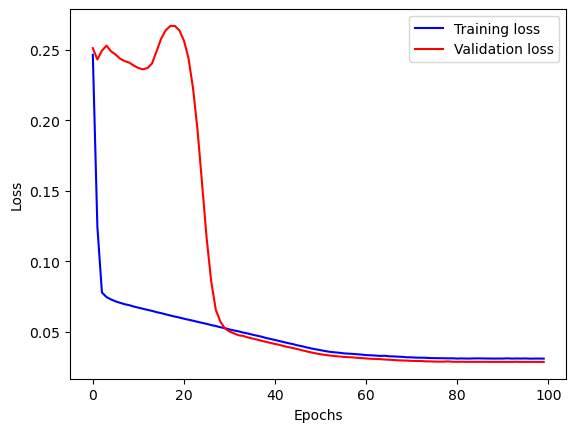

In [21]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
def build_logreg_model(keys, time_series_length):
    # Read all the inputs
    inputs = [
        keras.layers.Input(shape=(time_series_length,), name=key)
        for key in keys if key != "pct_mortality"
    ]

    # Reshape for concatenation
    reshapes = [
        keras.layers.Reshape((time_series_length, 1))(x) for x in inputs
    ]

    # Concatenate everybody together
    concat = keras.layers.Concatenate(axis=2)(reshapes)
    
    # Normalization
    norm = keras.layers.BatchNormalization(axis=2)(concat)

    # Flatten
    flat = keras.layers.Flatten()(norm)

    # Using a sigmoid activation function function as a logreg
    out = keras.layers.Dense(1, activation="sigmoid", name="pct_mortality", kernel_initializer="zeros")(flat)

    return keras.models.Model(inputs=inputs, outputs=out)

m_logreg = build_logreg_model(spec_io.keys(), 20)

In [23]:
m_logreg.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EVI_p5 (InputLayer)            [(None, 20)]         0           []                               
                                                                                                  
 EVI_p50 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 EVI_p95 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 dT_p5 (InputLayer)             [(None, 20)]         0           []                               
                                                                                            

In [24]:
m_logreg.compile(
    loss="mse",
    optimizer="Nadam"
)

In [25]:
history_logreg = m_logreg.fit(
    ds_train.batch(64),
    validation_data=ds_valid.batch(64),
    epochs=100,
    verbose=1
)

Epoch 1/100
20/20 [==============================] - 2s 43ms/step - loss: 0.1427 - val_loss: 0.0375
Epoch 2/100
20/20 [==============================] - 1s 18ms/step - loss: 0.0568 - val_loss: 0.0375
Epoch 3/100
20/20 [==============================] - 1s 17ms/step - loss: 0.0396 - val_loss: 0.0375
Epoch 4/100
20/20 [==============================] - 1s 18ms/step - loss: 0.0355 - val_loss: 0.0375
Epoch 5/100
20/20 [==============================] - 1s 17ms/step - loss: 0.0340 - val_loss: 0.0375
Epoch 6/100
20/20 [==============================] - 1s 20ms/step - loss: 0.0334 - val_loss: 0.0375
Epoch 7/100
20/20 [==============================] - 1s 18ms/step - loss: 0.0328 - val_loss: 0.0375
Epoch 8/100
20/20 [==============================] - 1s 18ms/step - loss: 0.0326 - val_loss: 0.0375
Epoch 9/100
20/20 [==============================] - 1s 17ms/step - loss: 0.0326 - val_loss: 0.0375
Epoch 10/100
20/20 [==============================] - 1s 19ms/step - loss: 0.0324 - val_loss: 0.0374

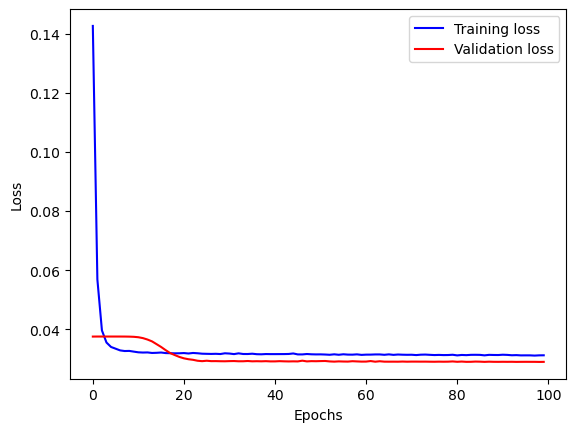

In [26]:
loss = history_logreg.history["loss"]
val_loss = history_logreg.history["val_loss"]
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
# Dummy model that returns a constant
def build_dummy_model(keys, time_series_length, constant):
    # Read all the inputs to make the API happy
    inputs = [
        keras.layers.Input(shape=(time_series_length,), name=key)
        for key in keys if key != "pct_mortality"
    ]

    # Reshape for concatenation
    reshapes = [
        keras.layers.Reshape((time_series_length, 1))(x) for x in inputs
    ]

    # Concatenate everybody together
    concat = keras.layers.Concatenate(axis=2)(reshapes)

    # Pass to dummy dense layer that returns a constant
    out = keras.layers.Dense(1, kernel_initializer="zeros", activation="linear", name="pct_mortality", 
                             bias_initializer=keras.initializers.Constant(constant), 
                             trainable=False)(concat)

    return keras.models.Model(inputs=inputs, outputs=out)

In [28]:
my_dummy = build_dummy_model(spec_io.keys(), 20, 0)
my_dummy.compile(
    loss="mse",
    optimizer="Nadam"
)

In [29]:
loss_dummy = my_dummy.evaluate(ds_valid.batch(64))

5/5 [==============================] - 0s 5ms/step - loss: 0.0375


In [32]:
# What is the baseline loss if we assume no mortality ever?
import numpy as np
y_test  = np.array([example[1]["pct_mortality"][-1].numpy() for example in ds_test.take(n_valid)])
y_guess = np.zeros(y_test.shape) + np.mean(y_test)

In [33]:
keras.losses.mean_squared_error(y_test, y_guess)

<tf.Tensor: shape=(), dtype=float64, numpy=0.031178856104304507>

In [35]:
keras.losses.mean_squared_error(y_test, np.zeros(y_test.shape))

<tf.Tensor: shape=(), dtype=float64, numpy=0.03616258857488236>

In [36]:
y_guess_lstm = m.predict(ds_valid.batch(64))

5/5 [==============================] - 1s 19ms/step


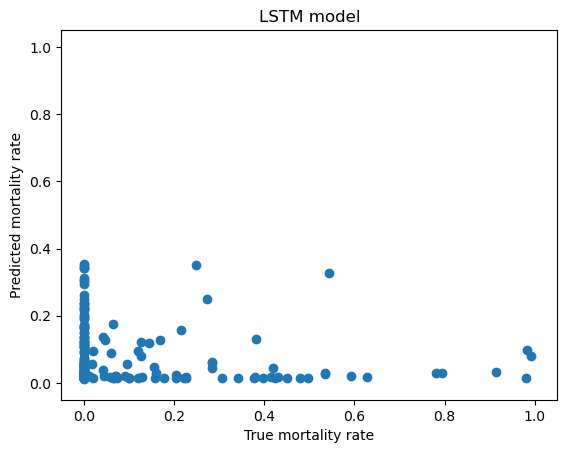

In [37]:
plt.scatter(y_test, y_guess_lstm)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("True mortality rate")
plt.ylabel("Predicted mortality rate")
plt.title("LSTM model")
plt.show()

In [38]:
loss_lstm = m.evaluate(ds_test.batch(64))

5/5 [==============================] - 0s 20ms/step - loss: 0.0313


In [39]:
loss_logreg = m_logreg.evaluate(ds_test.batch(64))

5/5 [==============================] - 0s 7ms/step - loss: 0.0317


In [41]:
# What about guessing the mean?
loss_dummy_mean = keras.losses.mean_squared_error(y_test, np.mean(y_test))

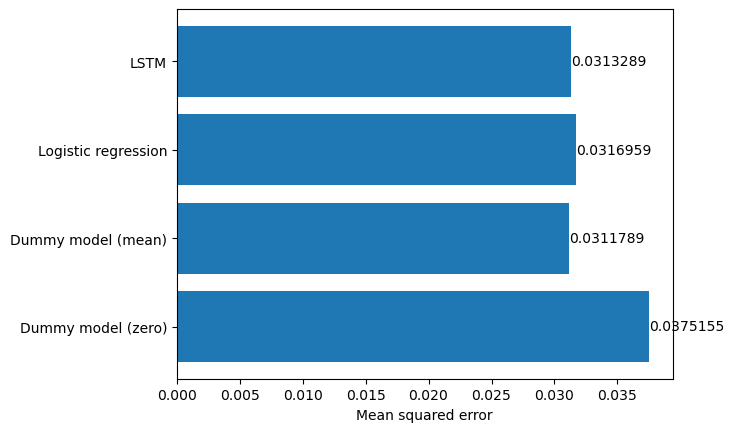

In [42]:
ax = plt.barh(
    ["Dummy model (zero)", "Dummy model (mean)", "Logistic regression", "LSTM"],
    [loss_dummy, loss_dummy_mean, loss_logreg, loss_lstm]
)
plt.bar_label(ax, label_type='edge')
plt.xlabel("Mean squared error")
plt.show()

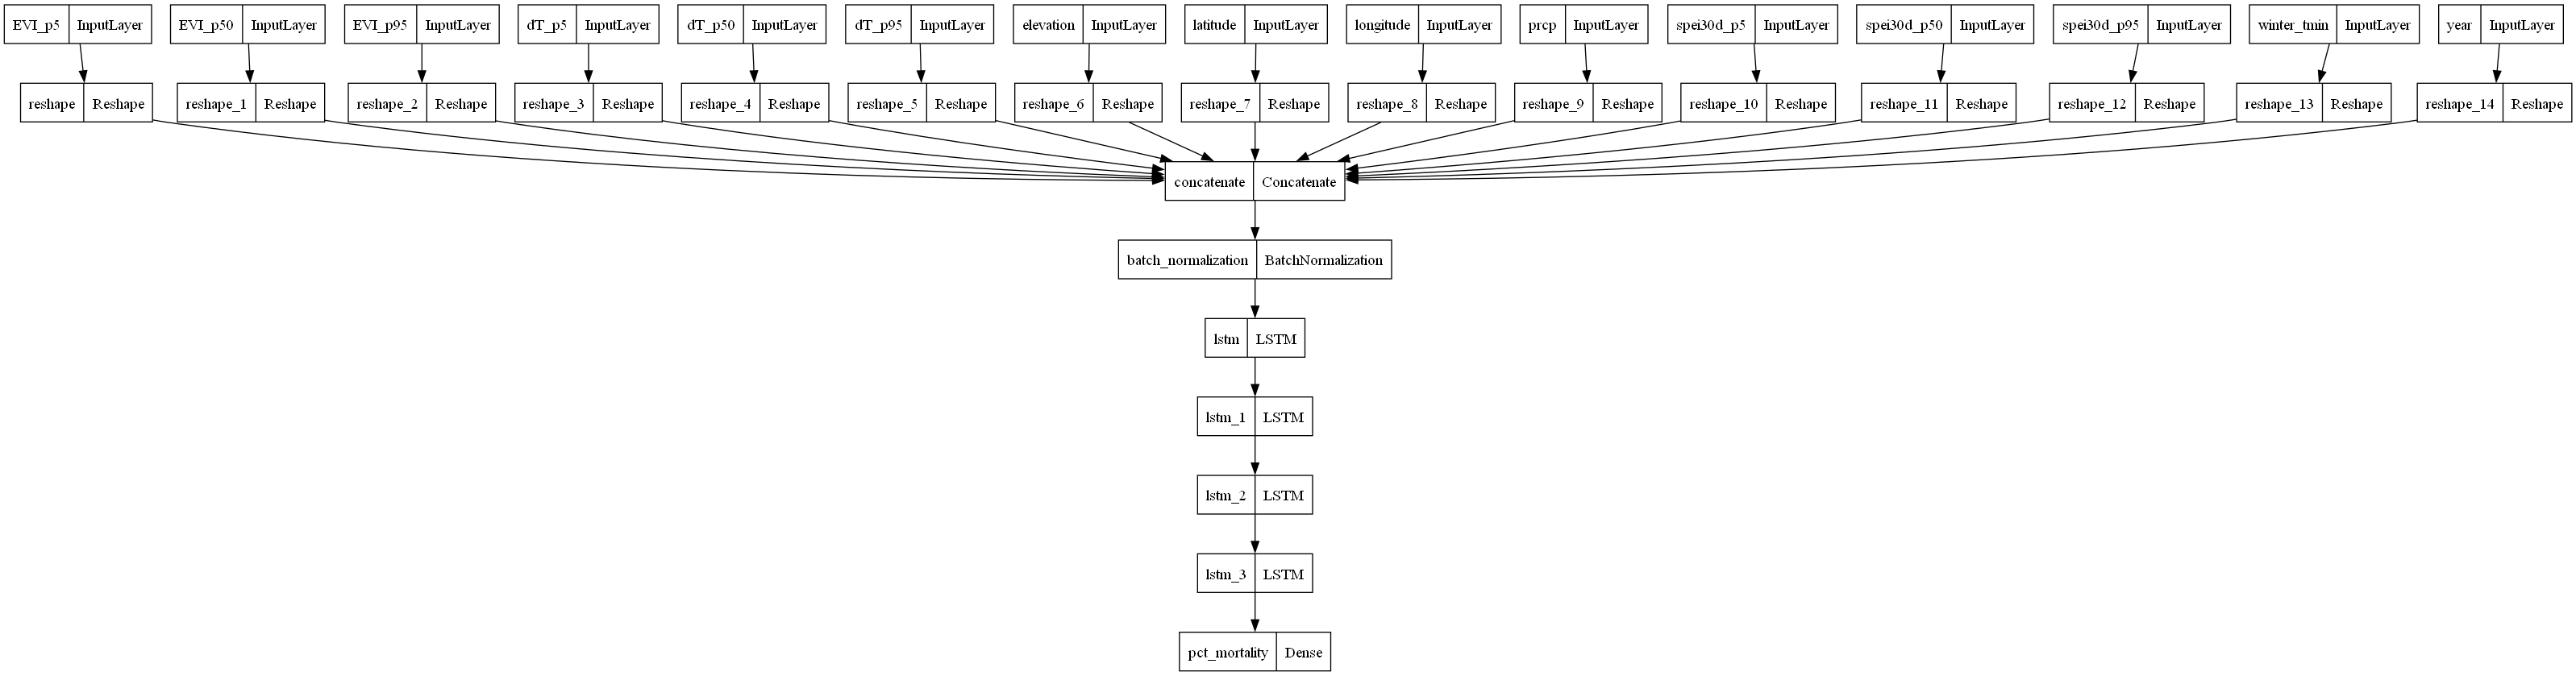

In [45]:
keras.utils.plot_model(m)